In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import csv
import collections
from collections import defaultdict
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import operator
import re 
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display
import seaborn as sns 

sys.path.append('../../transition-scenarios/scripts/')
import analysis as an

try:
    import cPickle as pickle 
except ImportError: 
    import pickle

In [3]:
!rm pride.sqlite
!cyclus pride.xml -o pride.sqlite --warn-limit 0

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [ ]:
!rm pride_max.sqlite
!cyclus pride.xml -o pride_max.sqlite --warn-limit 0

In [3]:
cursor_1 = an.get_cursor('pride.sqlite')
cursor_2 = an.get_cursor('pride_max.sqlite')
cursor_3 = an.get_cursor('pride_min.sqlite')

In [4]:
def stream_waste(cur):
    """ Find total isotopes present in spent fuel output by reactor for each cooling pool and sum cumulatively 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------

    """    
    
    streamlist = ["reduct_waste","volox_waste","winning_waste"]
    waste_dict = {}
    
    init_yr, init_month, duration, timestep = an.get_timesteps(cur)
    for stream in streamlist:
        waste = cur.execute('SELECT time, value FROM separationevents '
                            'WHERE Type= "%s"' %stream).fetchall()
        timeseries = an.get_timeseries(waste, duration, kg_to_tons=False)
        waste_dict[stream] = timeseries
    
    return waste_dict

In [5]:
waste_dict = stream_waste(cursor_1)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


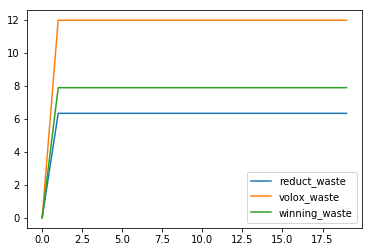

In [6]:
init_yr, init_month, duration, timestep = an.get_timesteps(cursor_1)
print(timestep)
for key, val in waste_dict.items():
    plt.plot(timestep, val, label=key)

plt.legend()
plt.show()
plt.close()

In [11]:
def stream_prod(cur):
    """ Find total quantity of each output stream 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    
    """    
    
    streamlist = ["refine_U_prod","refine_TRU_prod","leftover"]
    prod_dict = {}
    
    init_yr, init_month, duration, timestep = an.get_timesteps(cur)
    for stream in streamlist:
        prod = cur.execute('SELECT time, value FROM separationevents '
                            'WHERE Type= "%s"' %stream).fetchall()
        timeseries = an.get_timeseries(prod, duration, kg_to_tons=False)
        prod_dict[stream] = timeseries
    
    return prod_dict

In [12]:
prod_dict = stream_prod(cursor_1)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


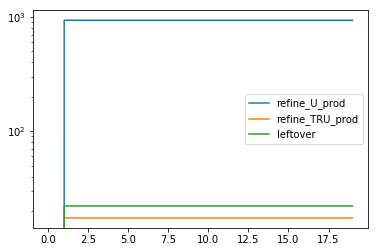

In [13]:
init_yr, init_month, duration, timestep = an.get_timesteps(cursor_1)
print(timestep)
for key, val in prod_dict.items():
    plt.semilogy(timestep, val, label=key)

plt.legend()
plt.show()
plt.close()

In [147]:
def isotope_total_cum(cur,num,in_dict):
    """ Find total isotopes present in each output stream 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    num: nucid 
    
    Returns 
    -------

    """    
    
    streamlist = ["reduct_waste","volox_waste","winning_waste","refine_U_prod","refine_TRU_prod"]
    isotope_total_list = []
    
    for stream in streamlist:    
        init_yr, init_month, duration, timestep = an.get_timesteps(cur)
        isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                               'INNER JOIN resources '
                               'ON transactions.resourceid = resources.resourceid '
                               'LEFT OUTER JOIN compositions '
                               'ON resources.qualid = compositions.qualid '
                               'WHERE Commodity =:stream AND nucid =:num ' # must specify isotope and stream
                               ' GROUP BY time ',{"stream": stream, "num":num}).fetchall()
        isotope_list = an.get_timeseries(isotopes,duration,False)
        isotope_total = np.sum(isotope_list)
        isotope_total_list.append(isotope_total)
    
    isotope_total_cum = np.cumsum(isotope_total_list)
    name = nn.name(num)
    in_dict[name] = isotope_total_cum
    return

In [149]:
dict_1 = {}
nucnum = [10030000,60140000,360860000,380900000,390900000,400950000,420950000,430990000,441010000,451030000,
461070000,471090000,521320000,531290000,541290000,551370000,561330000,571390000,581440000,591440000,601430000,
601450000,611470000,621470000,621490000,621500000,621510000,621520000,631530000,641550000,922340000,922350000,
922360000,922380000,932370000,942380000,942390000,942400000,942410000,942420000,952410000,952430000,962430000,
962440000,962450000]
for x in range(0,45):
    num = nucnum[x]
    isotope_total_cum(cursor_1,num,dict_1)
print(dict_1)

{'H3': array([0.        , 0.00089097, 0.00089097, 0.00089097, 0.00089097]), 'C14': array([0.        , 0.00144782, 0.00144782, 0.00144782, 0.00144782]), 'Kr86': array([0.        , 2.78427794, 2.78427794, 2.78427794, 2.78427794]), 'Sr90': array([10.32939816, 10.32939816, 10.32939816, 10.32939816, 10.32939816]), 'Y90': array([0.        , 0.        , 6.79456906, 6.79456906, 6.79456906]), 'Zr95': array([45.17184568, 45.17184568, 45.17184568, 45.17184568, 45.17184568]), 'Mo95': array([14.1836512 , 55.16822246, 55.16822246, 55.16822246, 55.16822246]), 'Tc99': array([ 0.        , 11.91670958, 11.91670958, 11.91670958, 11.91670958]), 'Ru101': array([ 0.        , 32.96585079, 32.96585079, 32.96585079, 32.96585079]), 'Rh103': array([1.85004146, 7.1958551 , 7.1958551 , 7.1958551 , 7.1958551 ]), 'Pd107': array([25.74641033, 25.74641033, 25.74641033, 25.74641033, 25.74641033]), 'Ag109': array([1.3875311, 1.3875311, 1.3875311, 1.3875311, 1.3875311]), 'Te132': array([ 0.        , 10.72503862, 10.72503

Text(0.5,1,'Isotopic Composition of Output Streams')

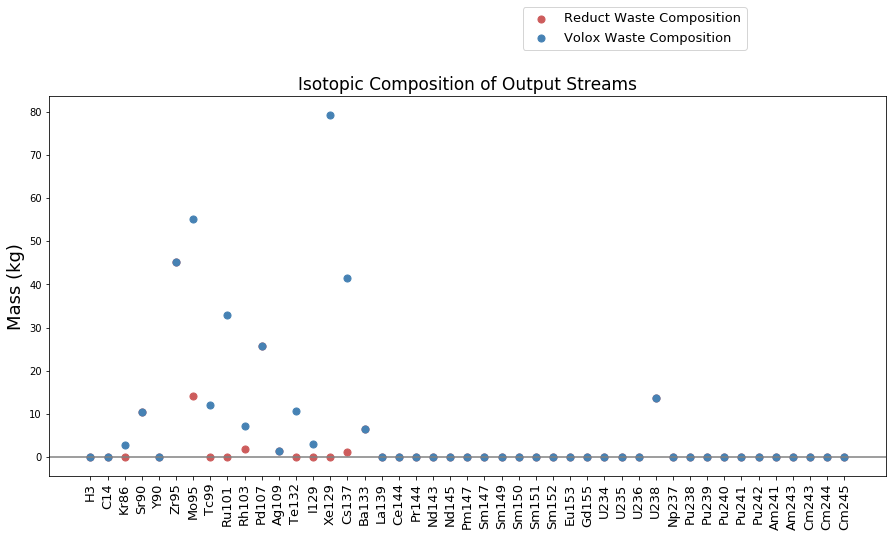

In [146]:
init_yr, init_month, duration, timestep = an.get_timesteps(cursor_1)
key_list = list(dict_1.keys())
y_pos = np.arange(len(key_list))
w = 45
h = 5
stream_ = [[0 for x in range(w)] for y in range(h)]

for y in range(0, 5):
    n = 0
    for key in key_list:
        temp = list(dict_1[key])
        stream_[y][n] = temp[y]
        n = n+1
    
#plt.scatter(range(1,46),stream_[0])  

fig, ax = plt.subplots(figsize=(15,7))
plt.axhline(y=0,color='grey')
ax.scatter(range(0,45),stream_[0],color = 'indianred', label='Reduct Waste Composition', marker = "o", s = 50)
ax.scatter(range(0,45),stream_[1],color = 'steelblue', label='Volox Waste Composition', marker = "o", s = 50)
#ax.scatter(range(0,45),stream_[2],color = 'lightgreen', label='Winning Waste Composition', marker = "o", s = 50)
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,key_list,rotation=90,fontsize=13)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
ax.set_ylabel('Mass (kg)', fontsize=18)
ax.set_title('Isotopic Composition of Output Streams' , fontsize=17)